# Check inclusive tagging on another channels: $B_d \to J \psi K^*, B_d \to J \psi K_s$

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import sys
sys.path.insert(0, "../")

In [4]:
import numpy
import pandas
import root_numpy
from sklearn.cross_validation import train_test_split
from utils import calibrate_probs, predict_by_estimator, compute_B_prob_using_part_prob
from utils import calculate_auc_with_and_without_untag_events, compute_mistag, result_table
from utils import compute_sum_of_charges, get_events_statistics, compute_N_B_events_MC, add_diff_pt
from scipy.special import logit

/mnt/mfs/miniconda/envs/rep_py2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Proportions of OS/SS and xFlag tags

In [5]:
dict_SS_OS = {'SS': 1, 'OS': -1, 'NAN': 0}

In [6]:
tag_kstar = pandas.read_csv('../datasets/MC/csv/WG/Bd_JPsiKstar/2012/Tracks.csv', sep='\t', 
                            usecols=['xFlag', 'OS_SS', 'BOosc'])
tag_ks = pandas.read_csv('../datasets/MC/csv/WG/Bd_JPsiKstar/2012/Tracks.csv', sep='\t',
                         usecols=['xFlag', 'OS_SS', 'BOosc'])
tag_k = pandas.read_csv('../datasets/MC/csv/WG/Bd_JPsiKstar/2012/Tracks.csv', sep='\t', 
                        usecols=['xFlag', 'OS_SS', 'BOosc'])

In [7]:
for br in ['xFlag', 'OS_SS']:
    print br
    for name, t in dict_SS_OS.items():
        print name, 
        print '\tK\t', 100. * sum(tag_k[br] == t) / len(tag_k[br]),
        print '\tK*\t', 100. * sum(tag_kstar[br] == t) / len(tag_kstar[br]),
        print '\tKs\t', 100. * sum(tag_ks[br] == t) / len(tag_ks[br])
    print '\n'

xFlag
SS 	K	8.72349679879 	K*	8.72349679879 	Ks	8.72349679879
NAN 	K	79.4370753257 	K*	79.4370753257 	Ks	79.4370753257
OS 	K	11.8394278755 	K*	11.8394278755 	Ks	11.8394278755


OS_SS
SS 	K	12.0946339114 	K*	12.0946339114 	Ks	12.0946339114
NAN 	K	71.8042682984 	K*	71.8042682984 	Ks	71.8042682984
OS 	K	16.1010977902 	K*	16.1010977902 	Ks	16.1010977902




## B oscillation flag

In [8]:
mask_ks = tag_ks['BOosc'] == 0
mask_kstar = tag_kstar['BOosc'] == 0

for name, t in dict_SS_OS.items():
    print name, 
    print '\tK*\t', 100. * sum(tag_kstar['xFlag'][mask_kstar] == t) / len(tag_kstar['xFlag'][mask_kstar]),
    print '\tKs\t', 100. * sum(tag_ks['xFlag'][mask_ks] == t) / len(tag_ks['xFlag'][mask_ks])

SS 	K*	10.1116714408 	Ks	10.1116714408
NAN 	K*	76.1461929781 	Ks	76.1461929781
OS 	K*	13.7421355811 	Ks	13.7421355811


### read $K^\pm$

In [9]:
k_data = pandas.read_csv('../models/part_tracks_MC.csv')

In [10]:
from utils import estimate_channel

In [11]:
from decisiontrain import DecisionTrainClassifier
from rep.estimators import SklearnClassifier
from folding_group import FoldingGroupClassifier

features = ['cos_diff_phi', 'diff_pt', 'partPt', 'partP', 'nnkrec', 'diff_eta', 'EOverP', 
            'ptB', 'sum_PID_mu_k', 'proj', 'PIDNNe', 'sum_PID_k_e', 'PIDNNk', 'sum_PID_mu_e', 'PIDNNm',
            'phi', 'IP', 'IPerr', 'IPs', 'veloch', 'max_PID_k_e', 'ghostProb', 
            'IPPU', 'eta', 'max_PID_mu_e', 'max_PID_mu_k', 'partlcs']

# Load models: classifier, calibrations, os/ss classifier

### Tracks and B models

In [12]:
import cPickle
with open('../models/dt_MC.pkl', 'r') as f:
    tt_folding = cPickle.load(f)

In [33]:
import cPickle
with open('../models/calibrator_tracks_MC2.pkl', 'r') as f:
    calibrator_tracks = cPickle.load(f)

In [32]:
import cPickle
with open('../models/calibrator_tracks_MC2.pkl', 'w') as f:
    cPickle.dump(calibrator_tracks, f)

In [14]:
import cPickle
with open('../models/calibrator_B_MC.pkl', 'r') as f:
    calibrator_B = cPickle.load(f)

/mnt/mfs/miniconda/envs/rep_py2/lib/python2.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator IsotonicRegression from version pre-0.18 when using version 0.18.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


### SS/OS discriminator

In [15]:
import cPickle 
with open('../models/dt_ss_os_only.pkl', 'r') as f:
    tt_os_ss = cPickle.load(f)

In [16]:
with open('../models/os_ss_calibrator_only.pkl', 'r') as f:
    calibrator_os_ss = cPickle.load(f)

In [17]:
from utils import data_tracks_preprocessing

# MC $B_d \to J/\psi K^*$

In [18]:
data_kstar = pandas.read_csv('../datasets/MC/csv/WG/Bd_JPsiKstar/2012/Tracks.csv', sep="\t")
data_kstar = data_tracks_preprocessing(data_kstar)

/mnt/mfs/miniconda/envs/rep_py2/lib/python2.7/site-packages/pandas/core/indexing.py:266: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/mnt/mfs/miniconda/envs/rep_py2/lib/python2.7/site-packages/pandas/core/indexing.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Initial statistics: {'parts': 9727928, 'Events': 431667}
after  (ghostProb < 0.4)  selection, statistics: {'parts': 9494829, 'Events': 431665}
after   ( (PIDNNk > 0.0) | (PIDNNm > 0.0) | (PIDNNe > 0.0) | (PIDNNpi > 0.0) | (PIDNNp > 0.0))   selection, statistics: {'parts': 9493367, 'Events': 431665}


In [19]:
# N_B_kstar = compute_N_B_events_MC('../datasets/MC/csv/WG/Bd_JPsiKstar/2012/Tracks.root',
                         #         '../datasets/MC/csv/WG/Bd_JPsiKstar/2012/Vertices.root')
N_B_kstar = 431667.0

In [20]:
N_B_kstar

431667.0

## Sum of charges

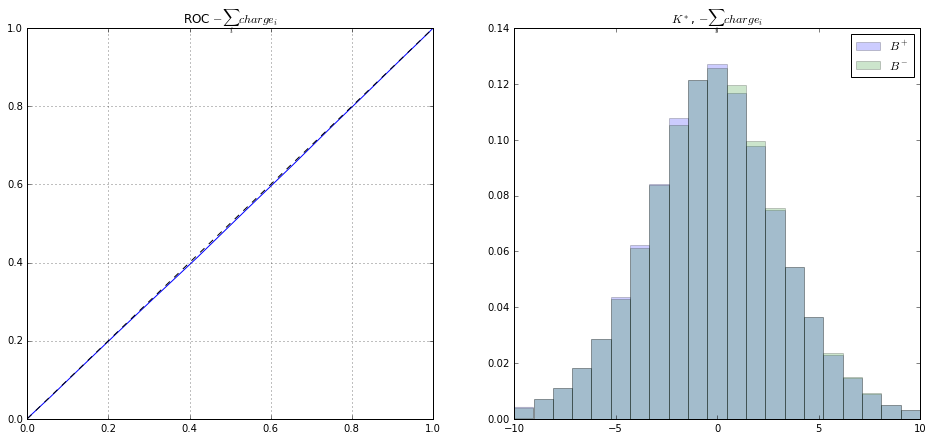

In [21]:
mean_kstar = compute_sum_of_charges(data_kstar, "$K^*$", bins=21,
                                    event_id_column='event_id', show_with_signal=False)

In [22]:
mean_kstar

,$B^+$,$B^-$,ROC AUC,name
0,-0.229751,-0.198957,0.497226,$K^*$


#### inverting of SS+NAN tags

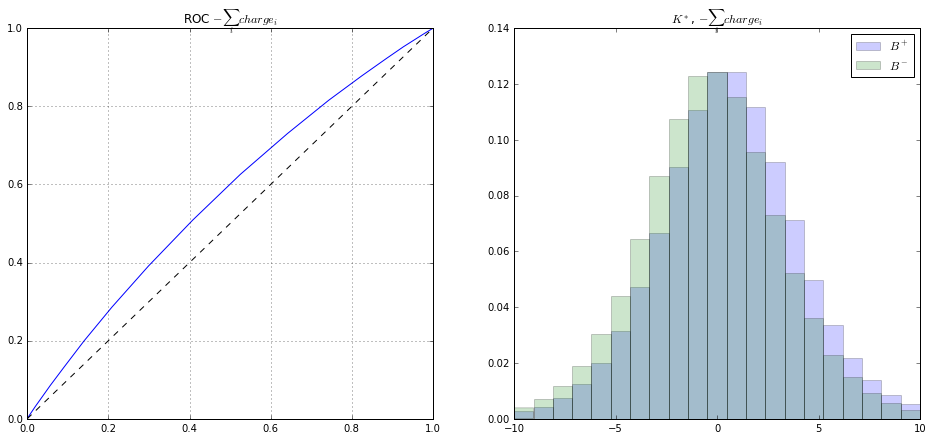

In [23]:
data_kstar_new = data_kstar.copy()
data_kstar_new.ix[data_kstar.OS_SS >= 0, 'signTrack'] *= -1
mean_kstar_invert = compute_sum_of_charges(data_kstar_new, "$K^*$", bins=21,
                                           event_id_column='event_id', show_with_signal=False)

In [24]:
mean_kstar_invert

,$B^+$,$B^-$,ROC AUC,name
0,0.589938,-0.272753,0.568555,$K^*$


### take predictions

In [25]:
p_kstar = tt_folding.predict_proba(data_kstar)[:, 1]
p_kstar_calib = calibrator_tracks.predict_proba(p_kstar)
p_kstar_ss = tt_os_ss.predict_proba(data_kstar)[:, 1]
p_kstar_ss_calib = calibrator_os_ss.predict_proba(p_kstar_ss)

KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)


### sum of charges of BDT inverting

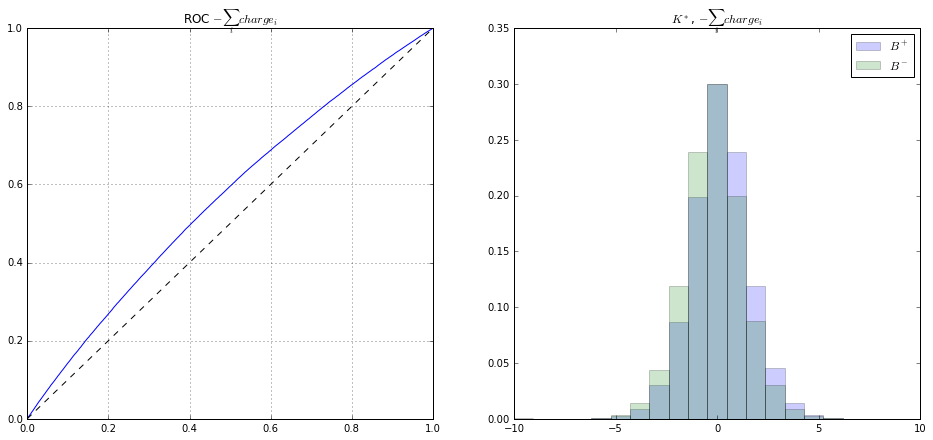

In [26]:
data_kstar_new = data_kstar.copy()
data_kstar_new['signTrack'] = data_kstar_new['signTrack'].values * (1 - p_kstar_ss_calib) + p_kstar_ss_calib * (-data_kstar_new['signTrack'].values)
mean_kstar_invert = compute_sum_of_charges(data_kstar_new, "$K^*$", bins=21,
                                           event_id_column='event_id', show_with_signal=False)

In [27]:
mean_kstar_invert

,$B^+$,$B^-$,ROC AUC,name
0,0.162803,-0.151672,0.564224,$K^*$


### AUCs for each type of tags

In [28]:
from sklearn.metrics import roc_auc_score

In [29]:
for br in ['xFlag', 'OS_SS']:
    print br
    for name, group in dict_SS_OS.items():
        mask = data_kstar[br].values == group
        print name, 'K*', roc_auc_score((data_kstar.signTrack.values * data_kstar.signB.values > 0)[mask], 
                                        p_kstar[mask]),
        mask = k_data[br].values == group
        print 'K+/-', roc_auc_score(k_data.label.values[mask], k_data.part_prob.values[mask])
    print '\n'

xFlag
SS K* 0.474724432887 K+/- 0.764816609728
NAN K* 0.500979795006 K+/- 0.508254738852
OS K* 0.540859990612 K+/- 0.567065103068


OS_SS
SS K* 0.473545260378 K+/- 0.626579880126
NAN K* 0.500014342914 K+/- 0.507681140994
OS K* 0.542346522475 K+/- 0.571539368791




## Final quality

In [30]:
os_region_mask = (data_kstar.IPs > 3) & ((abs(data_kstar.diff_eta) > 0.6) | (abs(data_kstar.diff_phi) > 0.825))
ss_region_mask = (abs(data_kstar.diff_eta) < 0.6) & (abs(data_kstar.diff_phi) < 0.825) & (data_kstar.IPs < 3)

### inverting tags

Calibrate tracks
tracks AUC 0.502917172452 calibrated tracks AUC 0.515399109807


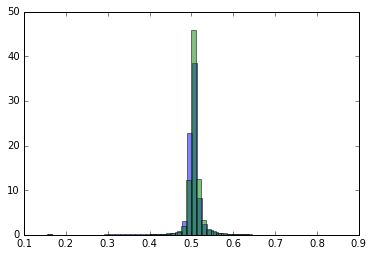

Calibrate B


AttributeError: 'IsotonicRegression' object has no attribute 'f_'

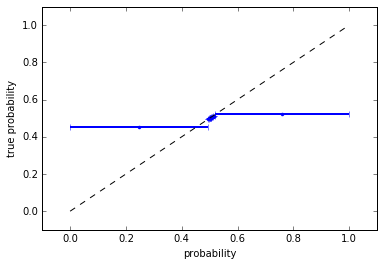

In [ ]:
table_kstar, _ = estimate_channel(p_kstar, data_kstar,
                               N_B_kstar, name="K*, OS/SS tag inverting", calibrator_tracks=calibrator_tracks, 
                               calibrator_B=calibrator_B, 
                               mask_to_invert=data_kstar.OS_SS.values >= 0)
table_kstar

Calibrate tracks
tracks AUC 0.502917172419 calibrated tracks AUC 0.515399109863


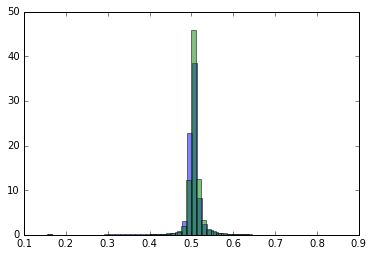

Calibrate B
dilution, without B calibration 0.0534907350113
B AUC, without calibration 0.628501649832 0.62850128435
B AUC, with calibration 0.628421748493 0.628421384589


,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,"K*, OS/SS tag inverting",99.999537,0.152203,0.083896,0,8.389534,0.012769,62.842138,0


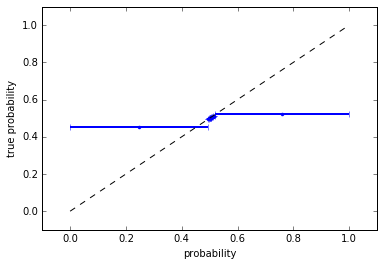

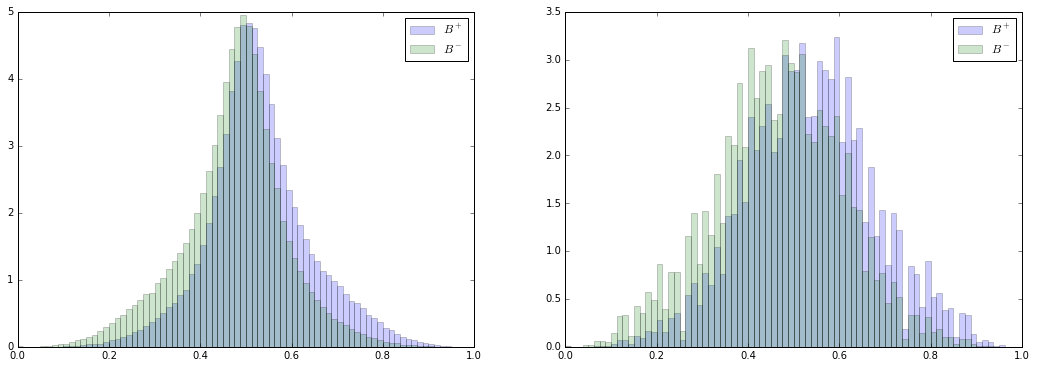

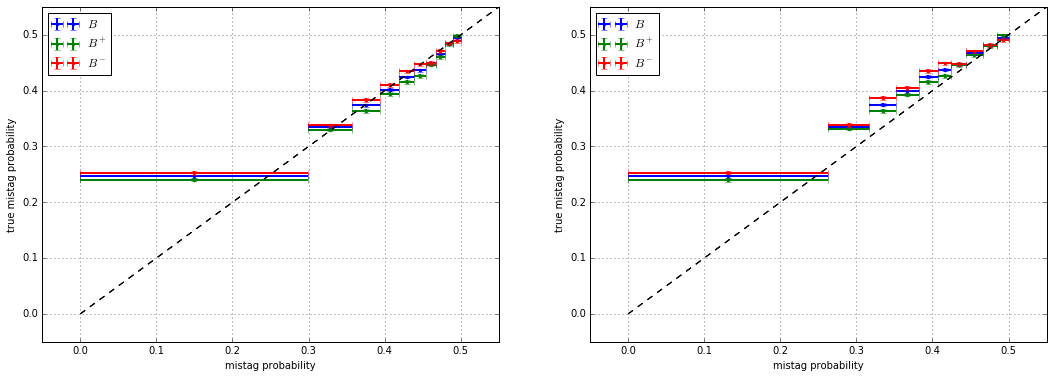

In [111]:
table_kstar, _ = estimate_channel(p_kstar, data_kstar,
                               N_B_kstar, name="K*, OS/SS tag inverting", calibrator_tracks=calibrator_tracks, 
                               calibrator_B=calibrator_B, 
                               mask_to_invert=data_kstar.OS_SS.values >= 0)
table_kstar

### inverting by BDT(SS/OS)

Calibrate tracks
tracks AUC 0.502917172419 calibrated tracks AUC 0.514632950594


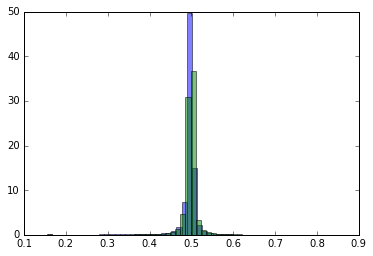

Calibrate B
dilution, without B calibration 0.0503057652211
B AUC, without calibration 0.62478036174 0.624779993969
B AUC, with calibration 0.624742294172 0.624741925402


,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,K* BDT inverting,99.999537,0.152203,0.07913,0,7.913013,0.012044,62.474193,0


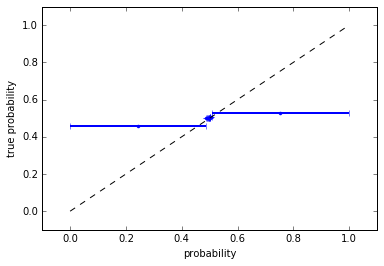

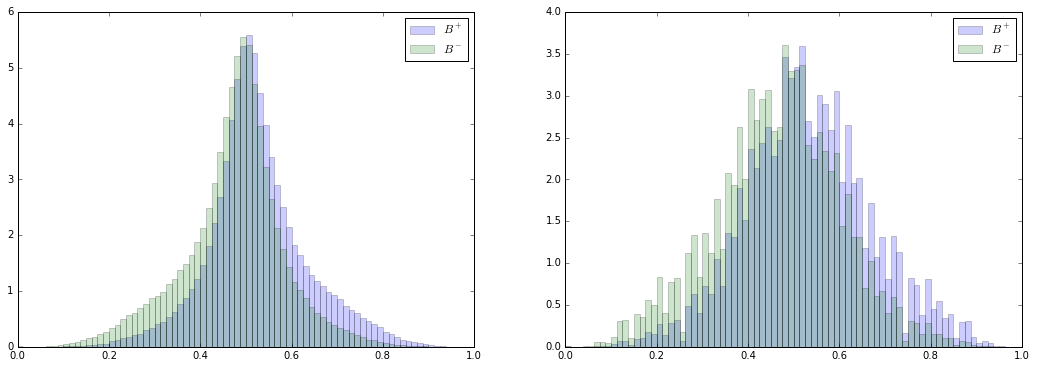

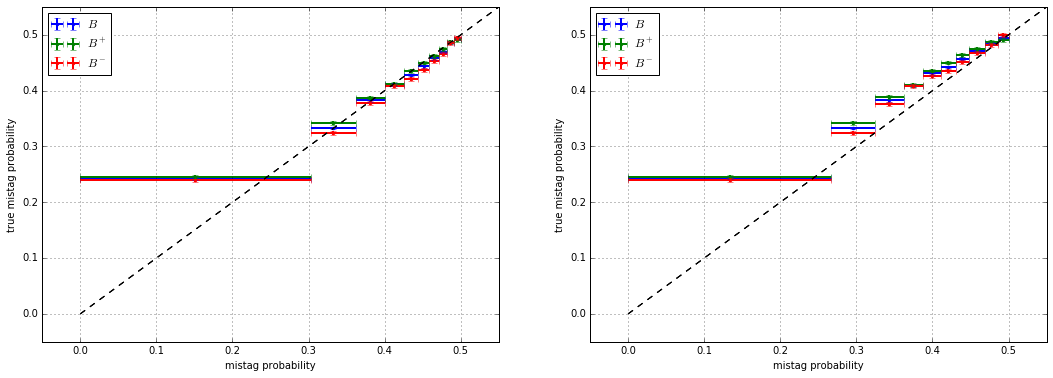

In [40]:
p_kstar_ss_calib_new = p_kstar_ss_calib.copy()
# p_kstar_ss_calib_new[data_kstar.OS_SS.values < 0] = 0.
# p_kstar_ss_calib_new[(data_kstar.OS_SS.values > 0) & (p_kstar_ss_calib_new <= 0.5)] = 0.
p_kstar_ss_calib_new[(p_kstar_ss_calib_new <= 0.5)] = 0.
p_kstar_ss_calib_new[data_kstar.OS_SS.values < 0] = 0.

table_kstar_BDT, prepared_data = estimate_channel(p_kstar, data_kstar,
                                                  N_B_kstar, name="K* BDT inverting", 
                                                  calibrator_tracks=calibrator_tracks, 
                                                  calibrator_B=calibrator_B, 
                                                  prior=p_kstar_ss_calib_new, for_epm=True)
table_kstar_BDT

Calibrate tracks
tracks AUC 0.502917172419 calibrated tracks AUC 0.517819566722


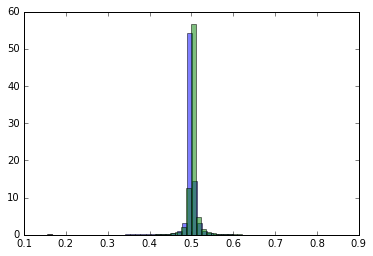

Calibrate B
dilution, without B calibration 0.0452491017566
B AUC, without calibration 0.644540096737 0.644539700348
B AUC, with calibration 0.644476640401 0.644476245276


,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,K* BDT inverting,99.999537,0.152203,0.071527,0,7.152702,0.010887,64.447625,0


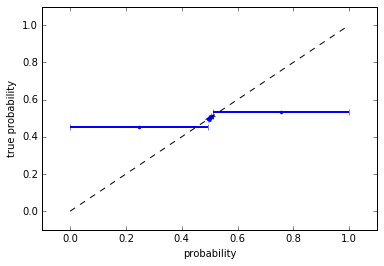

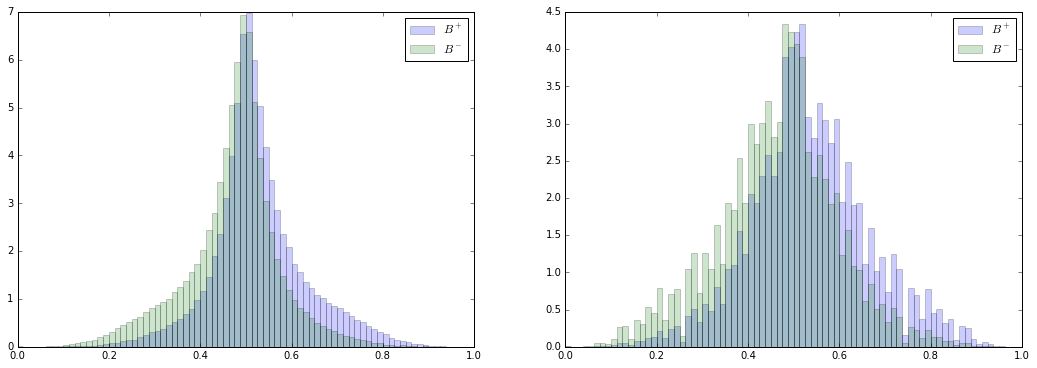

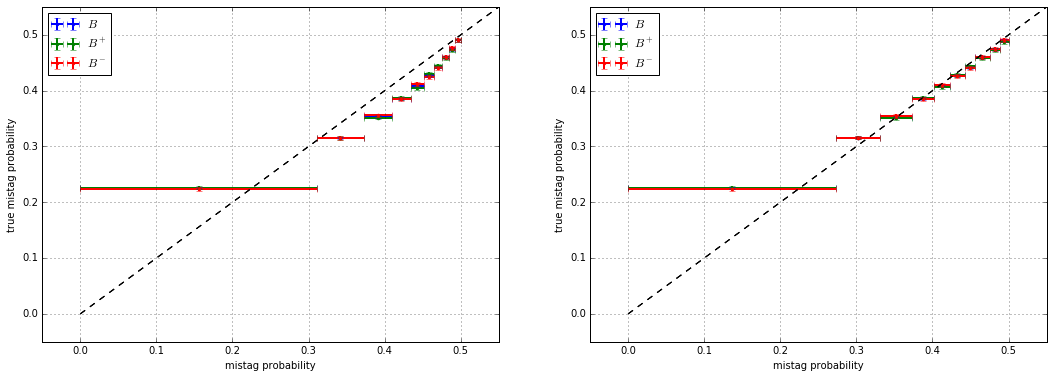

In [32]:
p_kstar_ss_calib_new = p_kstar_ss_calib.copy()
p_kstar_ss_calib_new[data_kstar.OS_SS.values < 0] = 0.
p_kstar_ss_calib_new[data_kstar.OS_SS.values == 1] = 1.

table_kstar_BDT, prepared_data = estimate_channel(p_kstar, data_kstar,
                                                  N_B_kstar, name="K* BDT inverting", 
                                                  calibrator_tracks=calibrator_tracks, 
                                                  calibrator_B=calibrator_B, 
                                                  prior=p_kstar_ss_calib_new, for_epm=True)
table_kstar_BDT

In [33]:
root_numpy.array2root(prepared_data.to_records(index=False), "../EPM/kstar_MC_inclusive.root", 
                      mode='recreate')

Calibrate tracks
tracks AUC 0.502917172419 calibrated tracks AUC 0.513539044233


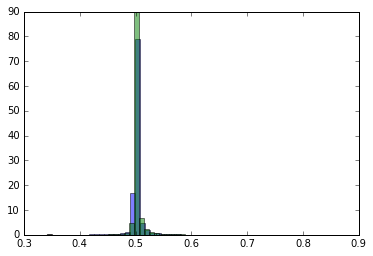

Calibrate B
dilution, without B calibration 0.0202236983448
B AUC, without calibration 0.607547740805 0.607547450546
B AUC, with calibration 0.607445043044 0.607444752749


,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,K* BDT inverting,99.999537,0.152203,0.035949,0,3.594866,0.005472,60.744475,0


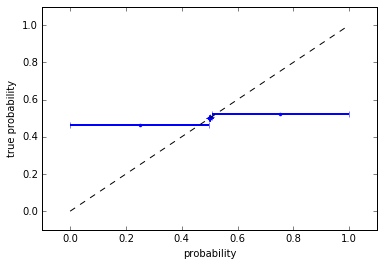

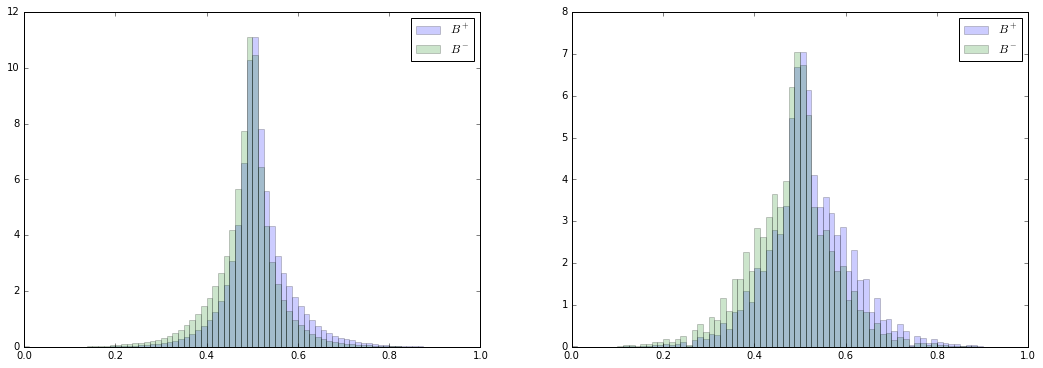

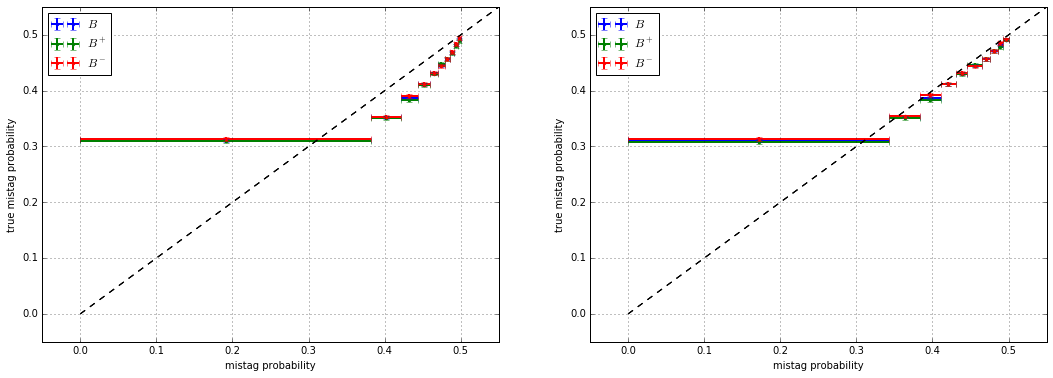

In [30]:
table_kstar_BDT, prepared_data = estimate_channel(p_kstar, data_kstar,
                                                  N_B_kstar, name="K* BDT inverting", 
                                                  calibrator_tracks=calibrator_tracks, 
                                                  calibrator_B=calibrator_B, 
                                                  prior=p_kstar_ss_calib, for_epm=True)
table_kstar_BDT

In [31]:
root_numpy.array2root(prepared_data.to_records(index=False), "../EPM/kstar_MC_inclusive.root", 
                      mode='recreate')

Calibrate tracks
tracks AUC 0.502917172419 calibrated tracks AUC 0.512131788234


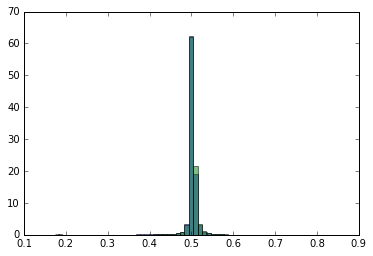

Calibrate B
dilution, without B calibration 0.037997157012
B AUC, without calibration 0.620437687771 0.620437322395
B AUC, with calibration 0.620394187492 0.620393821188


,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,K* BDT inverting,99.999537,0.152203,0.061368,0,6.136741,0.00934,62.039382,0


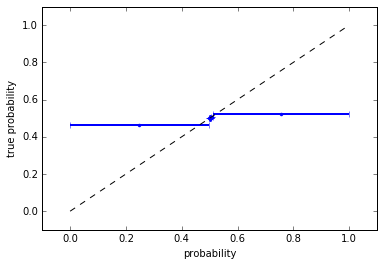

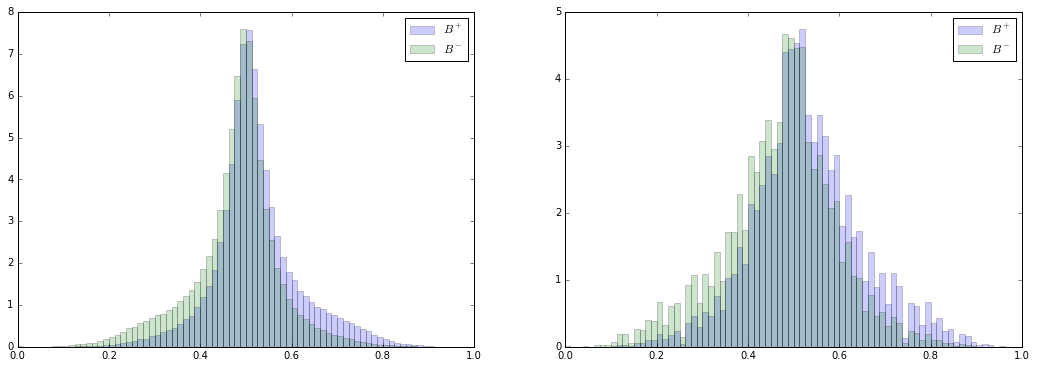

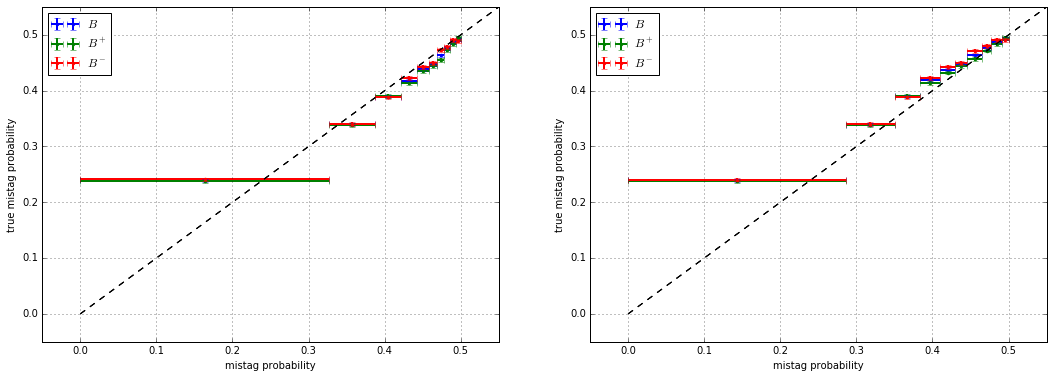

In [112]:
table_kstar_BDT, prepared_data = estimate_channel(p_kstar, data_kstar,
                                                  N_B_kstar, name="K* BDT inverting", 
                                                  calibrator_tracks=calibrator_tracks, 
                                                  calibrator_B=calibrator_B, 
                                                  prior=p_kstar_ss_calib, for_epm=True)
table_kstar_BDT

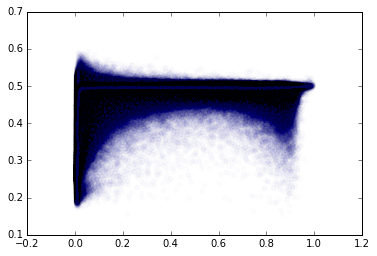

In [121]:
scatter(p_kstar_ss_calib[data_kstar.OS_SS.values == -1], p_kstar_calib[data_kstar.OS_SS.values == -1], alpha=0.01)

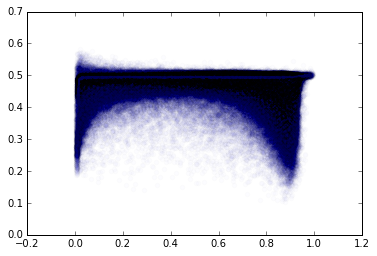

In [122]:
scatter(p_kstar_ss_calib[data_kstar.OS_SS.values == 1], p_kstar_calib[data_kstar.OS_SS.values == 1], alpha=0.01)

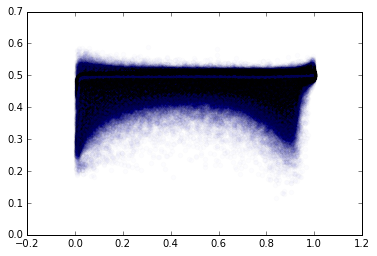

In [123]:
scatter(p_kstar_ss_calib[data_kstar.OS_SS.values == 0], p_kstar_calib[data_kstar.OS_SS.values == 0], alpha=0.01)

### inverting by BDT and SS/OS

Calibrate tracks
tracks AUC 0.502917172419 calibrated tracks AUC 0.517148508198


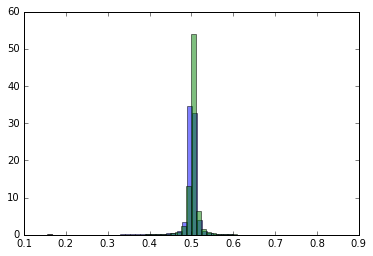

Calibrate B
dilution, without B calibration 0.0466409947162
B AUC, without calibration 0.6417158765 0.641715481606
B AUC, with calibration 0.641662025474 0.641661630037


,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,K* BDT inverting,99.999537,0.152203,0.073731,0,7.373087,0.011222,64.166163,0


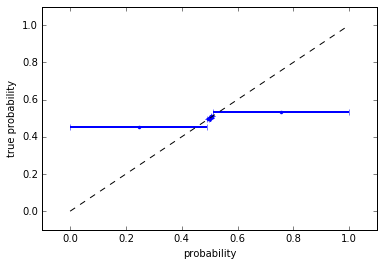

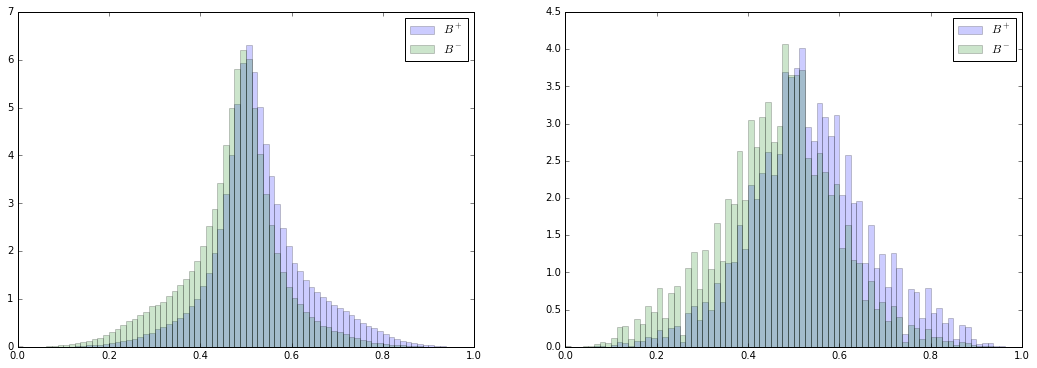

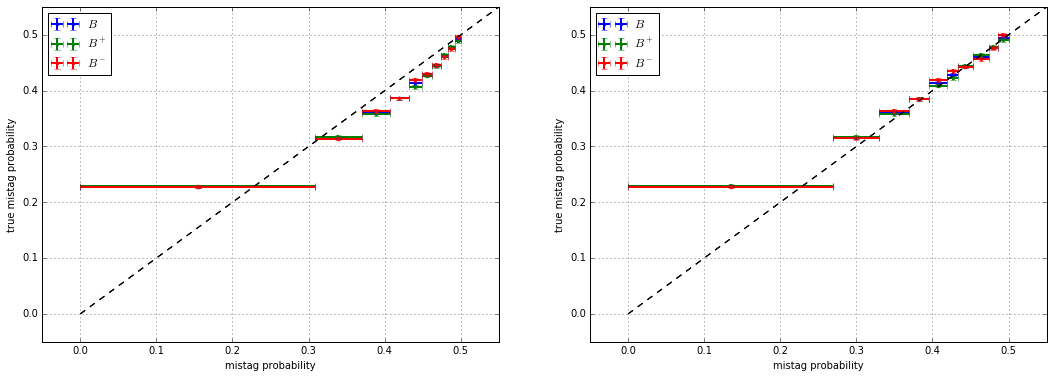

In [151]:
p_kstar_ss_calib_new = p_kstar_ss_calib.copy()
p_kstar_ss_calib_new[data_kstar.OS_SS.values < 0] = 0.
p_kstar_ss_calib_new[data_kstar.OS_SS.values == 1] = 1.
table_kstar_BDT, prepared_data = estimate_channel(p_kstar, data_kstar,
                                                  N_B_kstar, name="K* BDT inverting", 
                                                  calibrator_tracks=calibrator_tracks, 
                                                  calibrator_B=calibrator_B, 
                                                  prior=p_kstar_ss_calib_new, for_epm=True)
table_kstar_BDT

In [152]:
root_numpy.array2root(prepared_data.to_records(index=False), "../EPM/kstar_MC_inclusive.root", 
                      mode='recreate')

### self training

In [116]:
data_kstar['label'] = (data_kstar.signB.values * data_kstar.signTrack.values > 0) * 1

In [117]:
tt_base = DecisionTrainClassifier(learning_rate=0.02, n_estimators=3000, depth=6,
                                  max_features=15, n_threads=12)
tt_folding_kstar = FoldingGroupClassifier(SklearnClassifier(tt_base), n_folds=2, random_state=11, 
                                          train_features=features, group_feature='group_column')
%time tt_folding_kstar.fit(data_kstar, data_kstar.label)

CPU times: user 31min 15s, sys: 11.4 s, total: 31min 26s
Wall time: 5min 9s


FoldingGroupClassifier(base_estimator=SklearnClassifier(clf=DecisionTrainClassifier(bootstrap=True, depth=6, l2_regularization=100.0,
            learning_rate=0.02, loss=None, max_features=15,
            n_estimators=3000, n_threads=12, train_features=None,
            update_step=4, use_friedman_mse=True),
         features=None),
            group_feature='group_column', n_folds=2, parallel_profile=None,
            random_state=11,
            train_features=['cos_diff_phi', 'diff_pt', 'partPt', 'partP', 'nnkrec', 'diff_eta', 'EOverP', 'ptB', 'sum_PID_mu_k', 'proj', 'PIDNNe', 'sum_PID_k_e', 'PIDNNk', 'sum_PID_mu_e', 'PIDNNm', 'phi', 'IP', 'IPerr', 'IPs', 'veloch', 'max_PID_k_e', 'ghostProb', 'IPPU', 'eta', 'max_PID_mu_e', 'max_PID_mu_k', 'partlcs'])

In [118]:
p_kstar_own = tt_folding_kstar.predict_proba(data_kstar)[:, 1]
roc_auc_score(data_kstar.label.values, p_kstar_own)

KFold prediction using folds column


0.51628902005610189

Calibrate tracks
tracks AUC 0.516289020056 calibrated tracks AUC 0.516258746325


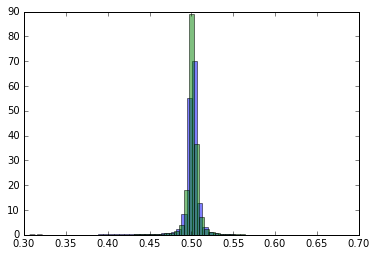

Calibrate B
dilution, without B calibration 0.0141034777273
B AUC, without calibration 0.633103413554 0.63310302329
B AUC, with calibration 0.632944953993 0.632944563813


,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,K* self training,99.999537,0.152203,0.058726,0,5.872574,0.008938,63.294456,0


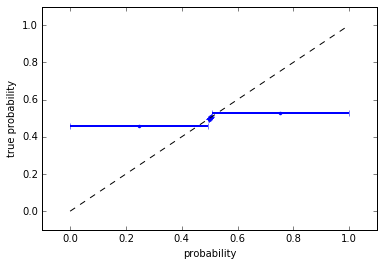

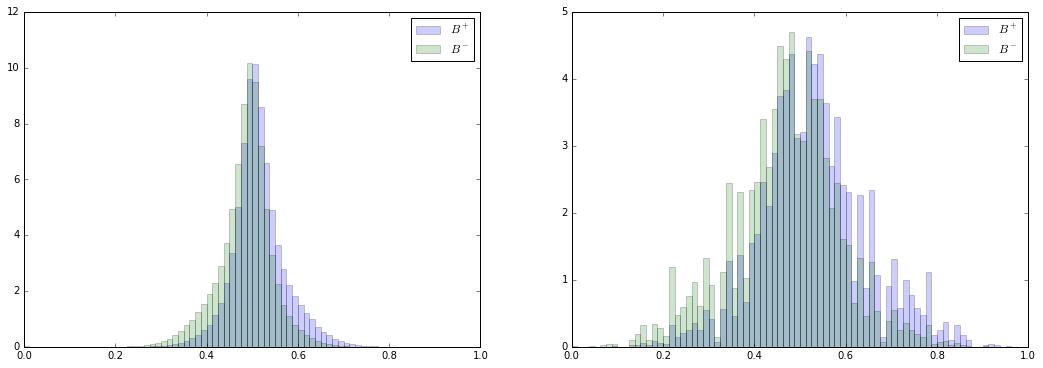

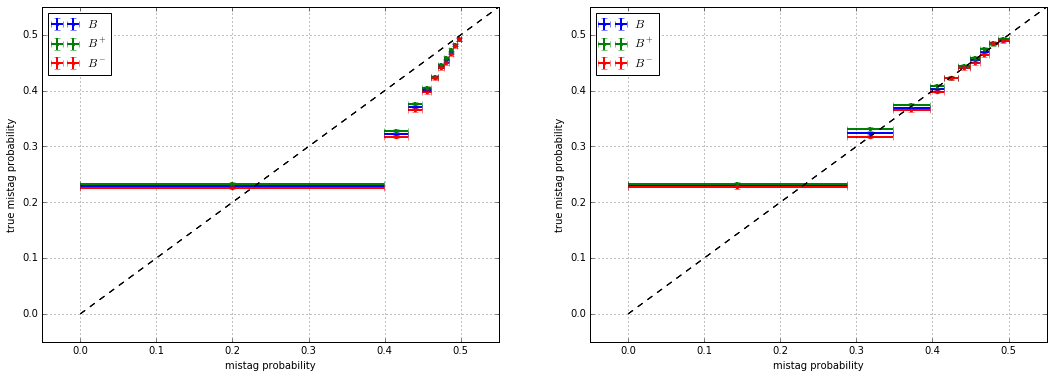

In [127]:
calibrator_tracks_kstar, calibrator_B_kstar, table_kstar_self, _ = estimate_channel(p_kstar_own, data_kstar,
                                                                                    N_B_kstar, name="K* self training")
table_kstar_self

In [128]:
p_kstar_own_calib = calibrator_tracks_kstar.predict_proba(p_kstar_own)

-------------------------

In [137]:
from scipy.special import logit, expit
p_corr = logit(p_kstar_own_calib) * logit(p_kstar_calib)
weight = numpy.ones(len(p_corr))
weight[abs(p_corr) < 0.05] = 0

In [140]:
p_corr_new = expit(p_corr)

In [139]:
sum(data_kstar.OS_SS.values < 0), sum(data_kstar.OS_SS.values > 0), sum(data_kstar.OS_SS.values == 0)

(1556133, 1170754, 6766480)

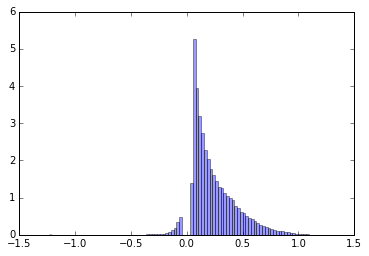

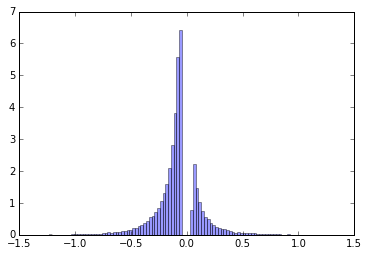

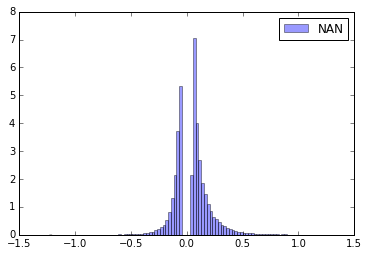

In [138]:
hist(p_corr, normed=True, alpha=0.4, label='OS', bins=100, weights=weight * (data_kstar.OS_SS.values < 0));
plt.show()
hist(p_corr, normed=True, alpha=0.4, label='SS', bins=100, weights=weight* (data_kstar.OS_SS.values > 0));
plt.show()
hist(p_corr, normed=True, alpha=0.4, label='NAN', bins=100, weights=weight * (data_kstar.OS_SS.values == 0));
legend();

--------------------

In [53]:
import cPickle
with open('../models/dt_kstar_MC.pkl', 'w') as f:
    cPickle.dump(tt_folding_kstar, f)
with open('../models/calibrator_tracks_kstar_MC.pkl', 'w') as f:
    cPickle.dump(calibrator_tracks_kstar, f)
with open('../models/calibrator_B_kstar_MC.pkl', 'w') as f:
    cPickle.dump(calibrator_B_kstar, f)

# MC $B_d \to J\psi K_s$

In [28]:
data_ks = pandas.read_csv('../datasets/MC/csv/WG/Bd_JPsiKs/2012/Tracks.csv', sep="\t")
data_ks = data_ks.ix[numpy.isfinite(data_ks.IPs), :]
add_features(data_ks)
get_events_statistics(data_ks)

{'Events': 130875, 'parts': 2837721}

In [29]:
# N_B_ks = compute_N_B_events_MC('datasets/MC/csv/Bd_JPsiKs/Tracks.root',
#                                'datasets/MC/csv/Bd_JPsiKs/Vertices.root')
N_B_ks = 130875.0

### initial selection

In [30]:
data_ks = data_ks.query(selection)
get_events_statistics(data_ks)

{'Events': 130875, 'parts': 2773602}

## Sum of charges

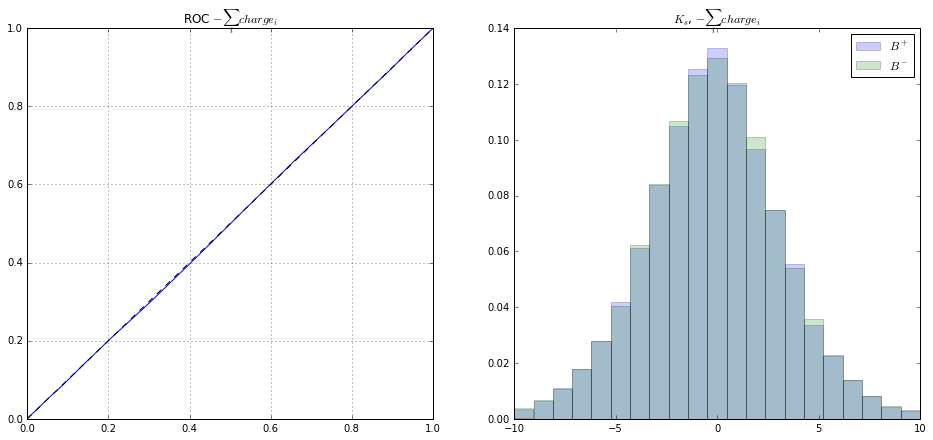

In [31]:
mean_ks = compute_sum_of_charges(data_ks, "$K_s$", bins=21, event_id_column='event_id', show_with_signal=False)

In [32]:
mean_ks

,$B^+$,$B^-$,ROC AUC,name
0,-0.21589,-0.211198,0.499283,$K_s$


#### inverting of SS+NAN tags

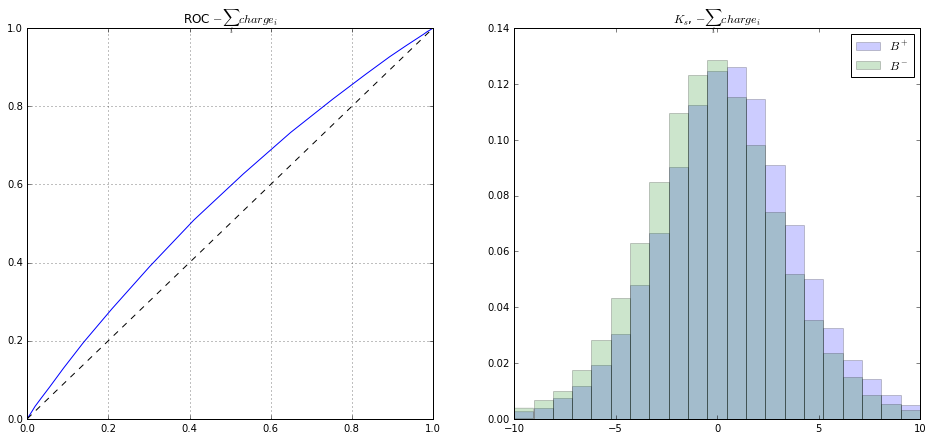

In [33]:
data_ks_new = data_ks.copy()
data_ks_new.ix[data_ks.OS_SS >= 0, 'signTrack'] *= -1
mean_ks_invert = compute_sum_of_charges(data_ks_new, "$K_s$", 
                                        bins=21, event_id_column='event_id', show_with_signal=False)

In [34]:
mean_ks_invert

,$B^+$,$B^-$,ROC AUC,name
0,0.594043,-0.214159,0.565251,$K_s$


### take predictions

In [35]:
p_ks = tt_folding.predict_proba(data_ks)[:, 1]
p_ks_ss = tt_os_ss.predict_proba(data_ks)[:, 1]
p_ks_ss_calib = calibrator_os_ss.predict_proba(p_ks_ss)

KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)


### AUCs for each type of tags

In [36]:
for name, group in dict_SS_OS.items():
    mask = data_ks.OS_SS.values == group
    print name, 'Ks', roc_auc_score((data_ks.signTrack.values * data_ks.signB.values > 0)[mask], p_ks[mask]),
    mask = k_data.OS_SS.values == group
    print 'K+-', roc_auc_score(k_data.label.values[mask], k_data.part_prob.values[mask])

SS Ks 0.414542354888 K+- 0.627365159203
NAN Ks 0.495801916674 K+- 0.507682309766
OS Ks 0.571681585497 K+- 0.571551314443


## Final quality

### inverting tags

Calibrate tracks
tracks AUC 0.502743200116 calibrated tracks AUC 0.515325748868


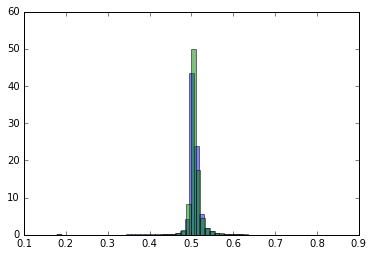

Calibrate B
dilution, without B calibration 0.0491703248157
B AUC, without calibration 0.624075281771 0.624075281771
B AUC, with calibration 0.624079833669 0.624079833669


,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,"Ks, OS/SS tag inverting",100,0.276421,0.076087,0,7.608653,0.021032,62.407983,0


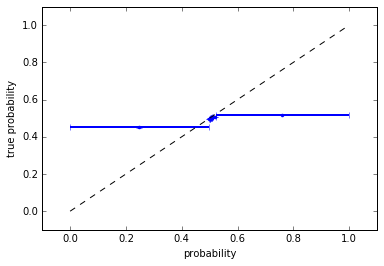

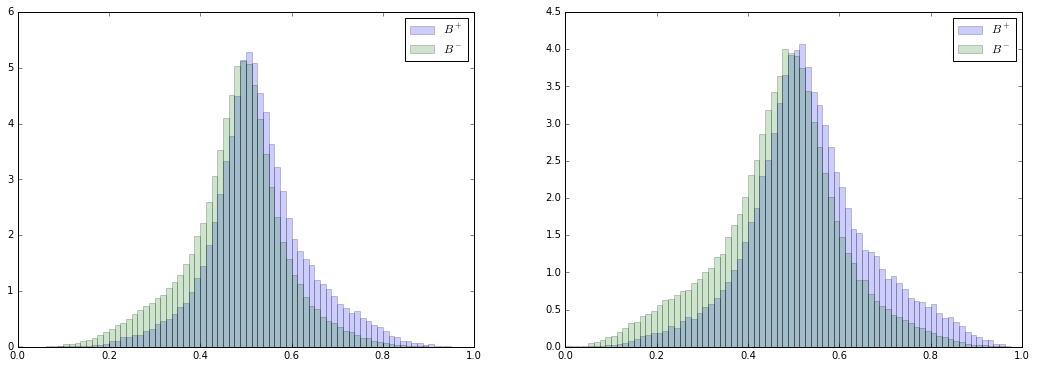

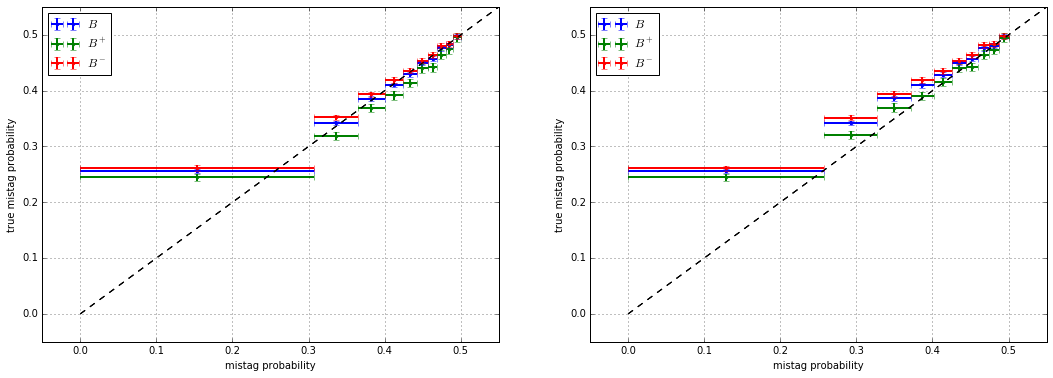

In [37]:
table_ks = estimate_channel(p_ks, data_ks,
                            N_B_ks, name="Ks, OS/SS tag inverting", calibrator_tracks=calibrator_tracks, 
                            calibrator_B=calibrator_B, 
                            mask_to_invert=data_ks.OS_SS.values >= 0)
table_ks

### inverting by BDT(SS/OS)

Calibrate tracks
tracks AUC 0.502743200116 calibrated tracks AUC 0.512593654583


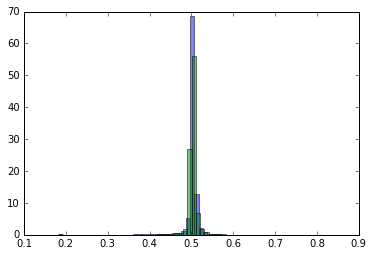

Calibrate B
dilution, without B calibration 0.0353781354752
B AUC, without calibration 0.617872029094 0.617872029094
B AUC, with calibration 0.617874172886 0.617874172886


,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,Ks BDT inverting,100,0.276421,0.05518,0,5.518005,0.015253,61.787417,0


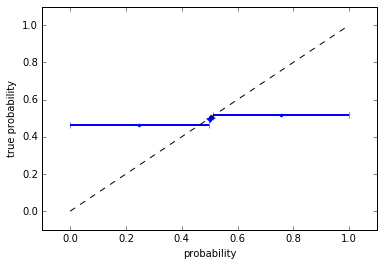

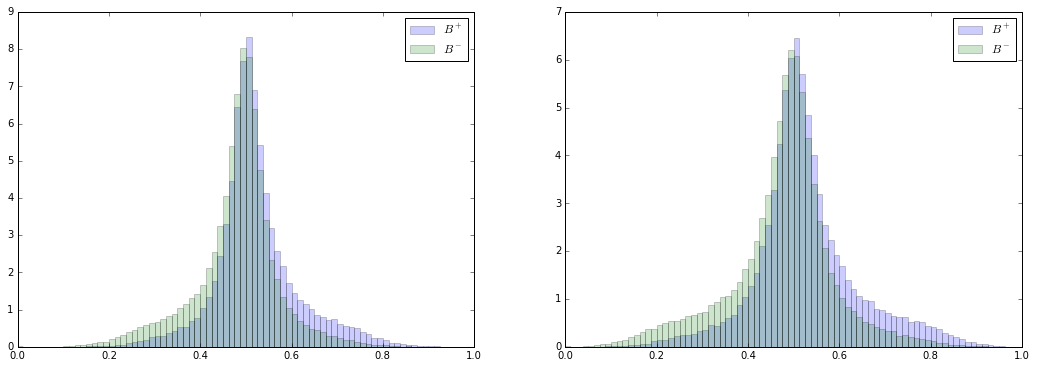

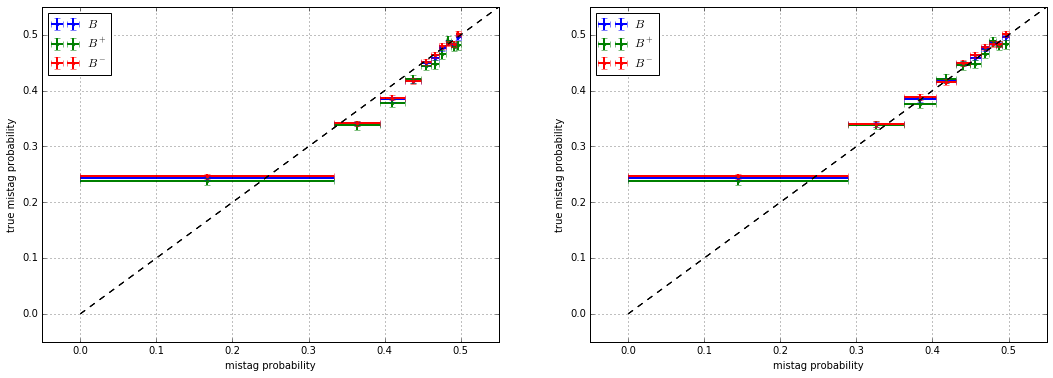

In [38]:
table_ks_BDT = estimate_channel(p_ks, data_ks,
                                N_B_ks, name="Ks BDT inverting", calibrator_tracks=calibrator_tracks, 
                                calibrator_B=calibrator_B, 
                                prior=p_ks_ss_calib)
table_ks_BDT

## self training

#### normalization

In [44]:
data_ks.index = range(len(data_ks))

In [45]:
_, ids = numpy.unique(data_ks.group_column, return_index=True)
ids_minus = ids[data_ks.ix[ids, 'signB'].values == -1]
ids_plus = ids[data_ks.ix[ids, 'signB'].values == 1]
print sum(data_ks.ix[ids, 'signB'] == 1), sum(data_ks.ix[ids, 'signB'] == -1)

40391 90484


In [46]:
data_ks.N_sig_sw = 1.
data_ks.ix[data_ks.signB == 1, 'N_sig_sw'] = 1. * sum(data_ks.ix[ids, 'signB'] == -1) / sum(data_ks.ix[ids, 'signB'] == 1)

In [47]:
ids_minus_take = numpy.random.choice(ids_minus, replace=False, size=len(ids_plus))

In [48]:
mask = numpy.in1d(data_ks.group_column.values, data_ks.group_column.values[ids_plus]) | \
       numpy.in1d(data_ks.group_column.values, data_ks.group_column.values[ids_minus_take])
data_ks_new = data_ks.loc[mask, :].copy()

In [49]:
data_ks_new.index = range(len(data_ks_new))
_, ids = numpy.unique(data_ks_new.group_column, return_index=True)
print sum(data_ks_new.ix[ids, 'signB'] == 1), sum(data_ks_new.ix[ids, 'signB'] == -1)

40391 40391


In [50]:
# N_B_ks_new = sum(data_ks.ix[ids, 'N_sig_sw'])
N_B_ks_new = len(numpy.unique(data_ks_new.group_column))
N_B_ks_new

80782

In [51]:
data_ks_new.N_sig_sw = 1

In [52]:
sum(data_ks_new.signB == 1), sum(data_ks_new.signB == -1)
sum(data_ks_new.signTrack == 1), sum(data_ks_new.signTrack == -1)

(863977, 846764)

In [53]:
sum(data_ks_new.label == 0), sum(data_ks_new.label == 1)

(855257, 855484)

In [54]:
data_ks_new['label'] = (data_ks_new.signB.values * data_ks_new.signTrack.values > 0) * 1
tt_base = DecisionTrainClassifier(learning_rate=0.01, n_estimators=1000, depth=6,
                                  n_threads=12)
tt_folding_ks = FoldingGroupClassifier(SklearnClassifier(tt_base), n_folds=2, random_state=15, 
                                       train_features=features, group_feature='group_column')
%time tt_folding_ks.fit(data_ks_new, data_ks_new.label)

CPU times: user 2min 34s, sys: 1.32 s, total: 2min 36s
Wall time: 24.7 s


FoldingGroupClassifier(base_estimator=SklearnClassifier(clf=DecisionTrainClassifier(bootstrap=True, depth=6, l2_regularization=100.0,
            learning_rate=0.01, loss=None, max_features=0.8,
            n_estimators=1000, n_threads=12, train_features=None,
            update_step=4, use_friedman_mse=True),
         features=None),
            group_feature='group_column', n_folds=2, parallel_profile=None,
            random_state=15,
            train_features=['cos_diff_phi', 'diff_pt', 'partPt', 'partP', 'nnkrec', 'diff_eta', 'EOverP', 'ptB', 'sum_PID_mu_k', 'proj', 'PIDNNe', 'sum_PID_k_e', 'PIDNNk', 'sum_PID_mu_e', 'PIDNNm', 'phi', 'IP', 'IPerr', 'IPs', 'veloch', 'max_PID_k_e', 'ghostProb', 'IPPU', 'eta', 'max_PID_mu_e', 'max_PID_mu_k', 'partlcs'])

In [55]:
p_ks_own = tt_folding_ks.predict_proba(data_ks_new)[:, 1]
roc_auc_score(data_ks_new.label, p_ks_own)

KFold prediction using folds column


0.51588438773352818

In [56]:
p, _ = calibrate_probs(data_ks_new.label.values, numpy.ones(len(data_ks_new)), p_ks_own, logistic=True,
                       random_state=42)

In [57]:
roc_auc_score(data_ks_new.label, p)

0.51523305002589803

KFold prediction using folds column
KFold prediction using folds column


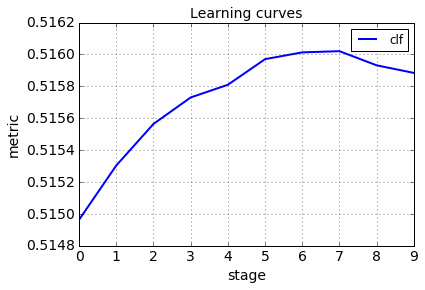

In [58]:
from rep.report.metrics import RocAuc
tt_folding_ks.test_on(data_ks_new, data_ks_new.label).learning_curve(RocAuc(), steps=1)

Calibrate tracks
tracks AUC 0.515884387734 calibrated tracks AUC 0.515849409222


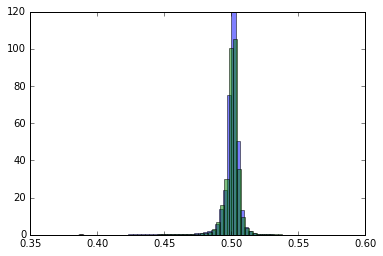

Calibrate B
dilution, without B calibration 0.00606396971905
B AUC, without calibration 0.62508644234 0.62508644234
B AUC, with calibration 0.624607403631 0.624607403631


,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,Ks self training,100,0.351838,0.052908,0,5.290838,0.018615,62.46074,0


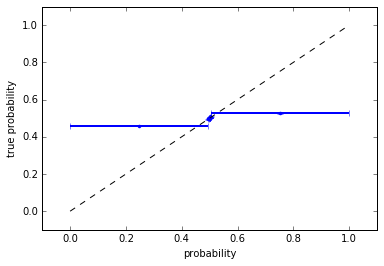

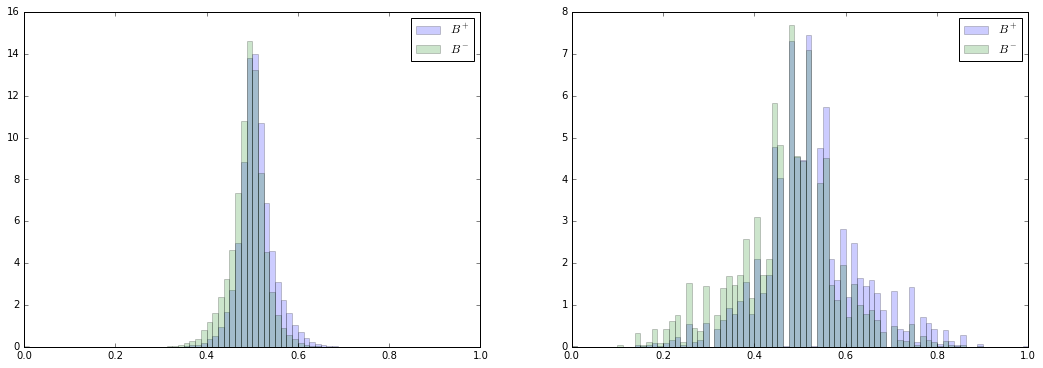

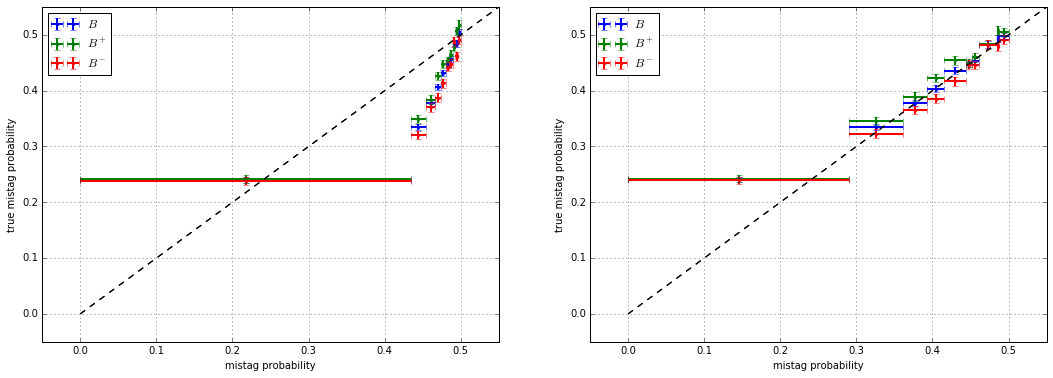

In [59]:
table_ks_self = estimate_channel(p_ks_own, data_ks_new, N_B_ks_new, name="Ks self training")
table_ks_self

# Final comparison

In [60]:
pandas.concat([table_kstar, table_ks])

,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,"K*, OS/SS tag inverting",99.999537,0.152203,0.081501,0,8.150099,0.012405,62.878995,0
0,"Ks, OS/SS tag inverting",100.000000,0.276421,0.076947,0,7.694698,0.021270,62.425092,0


In [61]:
pandas.concat([table_kstar_BDT, table_ks_BDT])

,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,K* BDT inverting,99.999537,0.152203,0.056434,0,5.643363,0.008589,61.846152,0
0,Ks BDT inverting,100.000000,0.276421,0.053501,0,5.350053,0.014789,61.621931,0


In [62]:
pandas.concat([table_kstar_self, table_ks_self])

,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,K* self training,99.999537,0.152203,0.058726,0,5.872583,0.008938,63.293779,0
0,Ks self training,100.000000,0.351838,0.052908,0,5.290838,0.018615,62.460740,0
